In [10]:
# all imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
metric = tf.keras.metrics

In [103]:
# First create new label based on stock performance relative to other stocks and benchmark
# Use the direct path to the file in the environment
input_file = 'sp1500_company_with_history_wide.csv'
benchmark_input_file = 'benchmark_history_180.csv'
df_raw = pd.read_csv(input_file)

benchmark_df = pd.read_csv(benchmark_input_file, parse_dates=['date'])
# protect against errors when computing pairwise daily returns
benchmark_df = benchmark_df.sort_values('date').reset_index(drop=True)

# convert date to YYYMMDD to match wide column suffixes
benchmark_df['date_key'] = benchmark_df['date'].dt.strftime("%Y%m%d")

# map the date_key to benchmark close price
benchmark_close = benchmark_df.set_index('date_key')['close']

# use log return - measurement of investment performance by ratio of final price to initial price
def log_return(final, initial):
    return np.log(final / initial)


# calculate z score for performance relative to others in each window
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean(skipna=True)
    sd = s.std(ddof=0, skipna=True)
    return (s - mu) / sd

# determine which dates exist in benchmark and company data

all_close_cols = [c for c in df_raw.columns if c.startswith("close_")]

# extract YYYMMDD part from close
company_dates = {c.split("_", 1)[1] for c in all_close_cols}

# keep only dates that are both in benchmark and company history
trade_days = [d for d in benchmark_df['date_key'] if d in company_dates]

# build relative daily returns feature in loop
rel_cols = []

for prev_key, curr_key in zip(trade_days[:-1], trade_days[1:]):
    close_prev = f"close_{prev_key}"
    close_curr = f"close_{curr_key}"

    # name of new feature for relative return
    feature_name = f"rel_ret{curr_key}"

    # stock daily log-return for the day
    stock_ret = log_return(df_raw[close_curr], df_raw[close_prev])

    # benchmark daily log-return for that day
    bench_ret = log_return(benchmark_close[curr_key], benchmark_close[prev_key])


    # relative performance vs benchmark
    df_raw[feature_name] = stock_ret - bench_ret
    rel_cols.append(feature_name)


# now compute z-score for each daily relative-return

z_cols = []

for col in rel_cols:
    z_name = f"z_{col}"
    df_raw[z_name] = zscore(df_raw[col])
    z_cols.append(z_name)


# build 30 day momentum score and label
z_df = df_raw[z_cols].copy()

# simple momentum measure: mean of per-day z-scores
momentum = z_df.mean(axis=1, skipna=True)

pct = momentum.rank(pct=True, method='average')

df_with_label = df_raw.copy()

# add labels based on percentage change
df_with_label['label'] = pd.cut(pct, 
                                bins=[-np.inf, 0.33, 0.66, np.inf],
                                labels=[0, 1, 2])

# drop Nans and cast label to int
df_with_label = df_with_label.dropna(subset=['label']).copy()
df_with_label['label'] = df_with_label['label'].astype('int32')


# add distance to 52 week extremes
rng = (df_with_label['fiftyTwoWeekHigh'] - df_with_label['fiftyTwoWeekLow']).replace(0, np.nan)
df_with_label['pos_in_52w'] = (df_with_label['currentPrice'] - df_with_label['fiftyTwoWeekLow']) / (rng + 1e-9)

# add distance to moving averages
df_with_label['dist_ma50']  = (df_with_label['currentPrice'] - df_with_label['fiftyDayAverage']) / (df_with_label['fiftyDayAverage'] + 1e-9)
df_with_label['dist_ma200'] = (df_with_label['currentPrice'] - df_with_label['twoHundredDayAverage']) / (df_with_label['twoHundredDayAverage'] + 1e-9)
df_with_label['ma_cross']   = (df_with_label['fiftyDayAverage'] - df_with_label['twoHundredDayAverage']) / (df_with_label['twoHundredDayAverage'] + 1e-9)

# add liquidity size, shares outstanding ratios
df_with_label['log_mcap']  = np.log(df_with_label['marketCap'] + 1)
# high outstanding shares = lots of flots is short and performance may be poor
df_with_label['float_to_out'] = df_with_label['floatShares'] / (df_with_label['sharesOutstanding'] + 1e-9)

# add z scores to the table for neural net to see each z score
for z_name in z_cols:
    df_with_label[z_name] = df_raw[z_name]

/var/folders/3_/q88t8wks1zvdr284_0m_frjc0000gn/T/ipykernel_49155/4107644400.py:5: DtypeWarning: Columns (192) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(input_file)
/var/folders/3_/q88t8wks1zvdr284_0m_frjc0000gn/T/ipykernel_49155/4107644400.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_raw[feature_name] = stock_ret - bench_ret
/var/folders/3_/q88t8wks1zvdr284_0m_frjc0000gn/T/ipykernel_49155/4107644400.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_raw[featu

In [104]:
# now add the new label and clean the dataframe by dropping low value columns

def clean_data(df):
    df_clean = df.copy()
    # remove columns that have no value for analysis, have large amount of
    # missing data
    drop_cols = ['companyOfficers', 'website', 'phone', 'irWebsite',
                 'longBusinessSummary', 'address1', 'tradeable', 'quoteType',
                 'language', 'region', 'quoteSourceName', 'triggerable', 
                 'customPriceAlertConfidence', 'marketState',
                 'exchangeDataDelayedBy', 'sourceInterval', 'cryptoTradeable',
                 'shortName', 'longName', 'hasPrePostMarketData',
                 'corporateActions', 'messageBoardId', 'exchangeTimezoneName',
                 'exchangeTimezoneShortName', 'gmtOffSetMilliseconds', 'fax',
                 'market', 'esgPopulated', 'address2', 'displayName',
                 'ipoExpectedDate', 'prevName', 'nameChangeDate',
                 'industrySymbol', 'trailingPegRatio', 'lastSplitDate', 
                 'lastSplitFactor', 'uuid']

    df_clean.drop(drop_cols, inplace=True, axis=1)
    # remove other columns that have high percentage of NaN values
    n_rows = len(df_clean)
    nan_pct = df_clean.isna().sum() / n_rows
    high_nan_cols = nan_pct[nan_pct >= 0.8].index.tolist()

    high_nan_cols = [c for c in high_nan_cols]
    df_clean.drop(high_nan_cols, axis=1, inplace=True)
    
    return df_clean

df_cleaned = clean_data(df_with_label)

# replace infinite values with NaN so imputer can handle them
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop columns with no data
df_cleaned.dropna(axis=1, how='all', inplace=True)
# show label column
print(df_cleaned['label'].head(20))
# show all columns
print(df_cleaned.columns.tolist())


0     1
1     0
2     1
3     1
4     0
5     0
6     2
7     2
8     1
9     2
10    0
11    1
12    1
13    2
14    0
15    0
16    2
17    1
18    1
19    2
Name: label, dtype: int32
['city', 'state', 'zip', 'country', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'fullTimeEmployees', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'executiveTeam', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bid', 'ask', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'allTimeHigh', 'allTimeLow', 'priceToS

In [105]:
# get all the time series columns we care about
prefix_groups = {
    "open": "open_",
    "close": "close_",
    "high": "high_",
    "low": "low_",
    "volume": "volume_",
    "vwap": "vwap_",
    "rel_ret": "rel_ret",
    "z_rel_ret": "z_rel_ret"
}
ts_cols_by_group = {}
for name, pref in prefix_groups.items():
    cols = [c for c in df_cleaned.columns if c.startswith(pref)]
    # sort by date suffix so time axis is ordered
    cols = sorted(cols, key=lambda c: c.split('_')[-1])
    ts_cols_by_group[name] = cols

# trim timesetp to the minimum timestep in the groups
min_timesteps = min(len(cols) for cols in ts_cols_by_group.values())
for name, cols in ts_cols_by_group.items():
    ts_cols_by_group[name] = cols[-min_timesteps:]

# flatten all time-series columns into a list to drop them
ts_all_cols = [c for cols in ts_cols_by_group.values() for c in cols]

# Impute missing values in time-series columns (per-column median)
df_cleaned[ts_all_cols] = df_cleaned[ts_all_cols].fillna(
    df_cleaned[ts_all_cols].median()
)

target = df_cleaned['label']
# static features are everything except label, symbol, and all time-series
static_features = df_cleaned.drop(columns=['label', 'symbol'] + ts_all_cols)

X_train_static, X_test_static, y_train, y_test = train_test_split(
    static_features,
    target,
    test_size=0.2,
    random_state=44)

# convert target labels to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# PROCESS THE STATIC FEATURES FIRST

# identify all numerical and categorical columns in the static train df
num_features = X_train_static.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train_static.select_dtypes(include=['object']).columns

# define a pipeline for numerical imputing and min max scaling
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])  # scale numerical features so no neg values

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# define processor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ],
    remainder='drop'
)

# fit only on train to avoid data leakage
X_train_static_proc = preprocessor.fit_transform(X_train_static).toarray()

# use only transform on test data to prevent data leakage
X_test_static_proc = preprocessor.transform(X_test_static).toarray()


# Now we can process the multi-channel time-series input for Conv1D
# get the same indices that we split on before
train_idx = X_train_static.index
test_idx = X_test_static.index

def make_ts_block(cols, train_idx, test_idx):
    # extract, scale, and return time series block for prefix
    X_train_block = df_cleaned.loc[train_idx, cols]
    X_test_block = df_cleaned.loc[test_idx, cols]
    
    # use standard scaler for time series blocks
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler.fit_transform(X_train_block)
    X_test_scaled = scaler.transform(X_test_block)
    return X_train_scaled, X_test_scaled, scaler

ts_train_blocks = []
ts_test_blocks = []
scalers_ts = {}

for name, cols in ts_cols_by_group.items():
    # get the train, test, and scaler for the block
    X_tr_block, X_te_block, scaler = make_ts_block(cols, train_idx, test_idx)
    scalers_ts[name] = scaler
    ts_train_blocks.append(X_tr_block)
    ts_test_blocks.append(X_te_block)

# get the timesteps for the groups
n_timesteps = ts_train_blocks[0].shape[1]
n_train = ts_train_blocks[0].shape[0]
n_test = ts_test_blocks[0].shape[0]
n_channels = len(ts_train_blocks)

# reshape each block to (batch, timesteps, 1) and stack as channels
train_channels = [block.reshape(n_train, n_timesteps, 1) for block in ts_train_blocks]
test_channels = [block.reshape(n_test, n_timesteps, 1) for block in ts_test_blocks]

X_train_ts = np.concatenate(train_channels, axis=2)
X_test_ts = np.concatenate(test_channels, axis=2)

# model can now take dual input for static and timeseries input

In [106]:
print("Any NaNs in X_train_ts?", np.isnan(X_train_ts).any())
print("NaN count in X_train_ts:", np.isnan(X_train_ts).sum())

for cls in range(3):
    mask = (y_train == cls)
    if mask.sum() == 0:
        print(f"Class {cls}: no samples")
        continue
    real_cls = X_train_ts[mask]
    print(
        f"Class {cls}: NaNs in real_cls?",
        np.isnan(real_cls).any(),
        "count:", np.isnan(real_cls).sum()
    )


Any NaNs in X_train_ts? False
NaN count in X_train_ts: 0
Class 0: NaNs in real_cls? False count: 0
Class 1: NaNs in real_cls? False count: 0
Class 2: NaNs in real_cls? False count: 0


In [65]:
layers = tf.keras.layers
metrics = tf.keras.metrics

# get the number of timesteps, channels, and static feature
n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]


# time series branch
ts_input = tf.keras.Input(shape=(n_timesteps, n_channels), name="time_series_input")

# define the time series branch of the convoluted NN
# follow similar structure as the neural network trained in part 1
# train static branch
# add max pooling
ts_branch = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='causal',
                          name='convo_layer_1')(ts_input)
ts_branch = layers.BatchNormalization(name='convo_batch_norm_1')(ts_branch)
ts_branch = layers.MaxPooling1D(pool_size=2, name='max_pooling')(ts_branch)
ts_branch = layers.Conv1D(filters=16, kernel_size=3, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(1e-3), padding='causal',
                          name='convo_layer_2')(ts_branch)
ts_branch = layers.BatchNormalization(name='convo_batch_norm_2')(ts_branch)
ts_branch = layers.GlobalAveragePooling1D(name='global_average_pooling')(ts_branch)
ts_branch = layers.Dropout(0.15, name='convo_dropout')(ts_branch)

# now train static branch
static_input = tf.keras.Input(shape=(n_static,), name='static_input')
# added batch normalization inside raw static input
static_branch = layers.BatchNormalization(name='static_batch_norm')(static_input)
# reduced dense layer neurons to 128
static_branch = layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                             name='static_dense_layer')(static_branch)
static_branch = layers.Dropout(0.2, name='static_dropout')(static_branch)
# merge branches
merged = layers.Concatenate(name='merge')([ts_branch, static_branch])
# add dense layer after merging
merged = layers.Dense(64, activation='relu', name='merged_dense_layer')(merged)
merged = layers.Dropout(0.3, name='merged_dropout')(merged)
output = layers.Dense(3, activation='softmax', name='prediction')(merged)


model_conv_ts_static = tf.keras.models.Model(
    inputs=[ts_input, static_input],
    outputs=output,
    name="conv1d_ts_plus_static_classifier"
)


top2_acc_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=2,
    name="top2_accuracy"
)

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_conv_ts_static.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        metrics.SparseCategoricalAccuracy(name='acc'),
        metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
        metrics.Precision(name='prec_under', class_id=0),
        metrics.Recall(name='rec_under', class_id=0),
        metrics.Precision(name='prec_neutral', class_id=1),
        metrics.Recall(name='rec_neutral', class_id=1),
        metrics.Precision(name='prec_over', class_id=2),
        metrics.Recall(name='rec_over', class_id=2),
    ]
)

# add neutral class weighting

class_weight = {
    0: 1.0,   # under
    1: 1.3,   # neutral (slightly up-weighted)
    2: 1.0    # over
}

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# train model
history = model_conv_ts_static.fit(
    [X_train_ts, X_train_static_proc],  # both inputs
    y_train,
    validation_data=([X_test_ts, X_test_static_proc], y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=2
)




Epoch 1/30
19/19 - 6s - 336ms/step - acc: 0.3912 - loss: 1.4841 - prec_neutral: 0.6947 - prec_over: 0.4693 - prec_under: 0.7534 - rec_neutral: 0.2188 - rec_over: 0.2517 - rec_under: 0.2489 - top2_acc: 0.7348 - val_acc: 0.3133 - val_loss: 1.1576 - val_prec_neutral: 0.8000 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0678 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7400
Epoch 2/30
19/19 - 1s - 54ms/step - acc: 0.4612 - loss: 1.3008 - prec_neutral: 0.6884 - prec_over: 0.8007 - prec_under: 0.7980 - rec_neutral: 0.2331 - rec_over: 0.2552 - rec_under: 0.2510 - top2_acc: 0.7623 - val_acc: 0.3200 - val_loss: 1.1389 - val_prec_neutral: 0.6667 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0424 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7100
Epoch 3/30
19/19 - 1s - 54ms/step - acc: 0.5279 - loss: 1.1720 - prec_neutral: 0.6140 - prec_over: 0.6984 - prec_under: 0.7021 - rec_ne

Wrap the CNN model in a wrapper function so we can retain it multiple times without pasting

In [63]:
def build_conv_ts_static_model(n_timesteps, n_channels, n_static):
    layers = tf.keras.layers
    metrics = tf.keras.metrics

    # time series branch
    ts_input = tf.keras.Input(shape=(n_timesteps, n_channels),
                              name="time_series_input")
    ts_branch = layers.Conv1D(
        filters=32, kernel_size=5, activation='relu', padding='causal',
        name='convo_layer_1'
    )(ts_input)
    ts_branch = layers.BatchNormalization(name='convo_batch_norm_1')(ts_branch)
    ts_branch = layers.MaxPooling1D(pool_size=2, name='max_pooling')(ts_branch)
    ts_branch = layers.Conv1D(
        filters=16, kernel_size=3, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-3),
        padding='causal',
        name='convo_layer_2'
    )(ts_branch)
    ts_branch = layers.BatchNormalization(name='convo_batch_norm_2')(ts_branch)
    ts_branch = layers.GlobalAveragePooling1D(
        name='global_average_pooling'
    )(ts_branch)
    ts_branch = layers.Dropout(0.15, name='convo_dropout')(ts_branch)

    # static branch
    static_input = tf.keras.Input(shape=(n_static,), name='static_input')
    static_branch = layers.BatchNormalization(
        name='static_batch_norm'
    )(static_input)
    static_branch = layers.Dense(
        128, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        name='static_dense_layer'
    )(static_branch)
    static_branch = layers.Dropout(0.2, name='static_dropout')(static_branch)

    # merge branches
    merged = layers.Concatenate(name='merge')([ts_branch, static_branch])
    merged = layers.Dense(64, activation='relu',
                          name='merged_dense_layer')(merged)
    merged = layers.Dropout(0.3, name='merged_dropout')(merged)
    output = layers.Dense(3, activation='softmax', name='prediction')(merged)

    model = tf.keras.Model(
        inputs=[ts_input, static_input],
        outputs=output,
        name="conv1d_ts_plus_static_classifier"
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            metrics.SparseCategoricalAccuracy(name='acc'),
            metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc'),
            metrics.Precision(name='prec_under', class_id=0),
            metrics.Recall(name='rec_under', class_id=0),
            metrics.Precision(name='prec_neutral', class_id=1),
            metrics.Recall(name='rec_neutral', class_id=1),
            metrics.Precision(name='prec_over', class_id=2),
            metrics.Recall(name='rec_over', class_id=2),
        ]
    )

    return model


10/10 - 1s - 75ms/step - acc: 0.6900 - loss: 0.6963 - prec_neutral: 0.4917 - prec_over: 0.6753 - prec_under: 0.6420 - rec_neutral: 0.3688 - rec_over: 0.2549 - rec_under: 0.2321 - top2_acc: 0.9633
loss: 0.6963
compile_metrics: 0.6900
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Macro F1: 0.6967
Weighted F1: 0.6999
              precision    recall  f1-score   support

       under       0.85      0.68      0.75       105
     neutral       0.51      0.71      0.59        94
        over       0.82      0.68      0.75       101

    accuracy                           0.69       300
   macro avg       0.72      0.69      0.70       300
weighted avg       0.73      0.69      0.70       300

[[71 34  0]
 [12 67 15]
 [ 1 31 69]]


<Axes: >

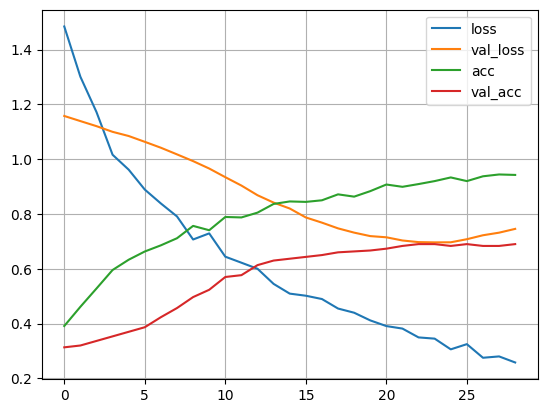

In [66]:
# Keras metrics
results = model_conv_ts_static.evaluate(
    [X_test_ts, X_test_static_proc],
    y_test,
    verbose=2
)

for name, value in zip(model_conv_ts_static.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions for sklearn metrics
probs = model_conv_ts_static.predict([X_test_ts, X_test_static_proc])
pred = probs.argmax(axis=1)

macro_f1 = f1_score(y_test, pred, average='macro')
weighted_f1 = f1_score(y_test, pred, average='weighted')

print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
))

print(confusion_matrix(y_test, pred))
pd.DataFrame(history.history)[['loss', 'val_loss', 'acc', 'val_acc']].plot(grid=True)

Model performance before adding GAN is 69% accuracy on a 3 way classification. The precision for the over and underperform classes are high and the precision for the neutral class is low.

Now we will add a GAN to generate time-series data and reuse the static features for class-balancing

In [31]:
# initial model

n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]

def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    # embed layer, concatenate into noise
    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    x = layers.Dense(n_timesteps * 64, activation='relu')(merged)
    x = layers.Reshape((n_timesteps, 64))(x)

    # Conv1D transpose
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='linear')(x)

    return tf.keras.Model([noise_input, label_input], out, name='generator')

def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    x = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='relu')(merged)
    x = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')

Define functions for training and generating model now that initial model is defined

In [ ]:
def train_gan(X_train_ts, y_train, epochs=200, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
                loss='binary_crossentropy')

    n_samples = X_train_ts.shape[0]
    d_losses, g_losses = [], []
    for epoch in range(epochs):
        idx = np.random.randint(0, n_samples, batch_size)
        real_ts = X_train_ts[idx]
        real_labels = y_train[idx].reshape(-1, 1)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_labels = np.random.randint(0, 3, (batch_size, 1))
        fake_ts = generator.predict([noise, fake_labels], verbose=0)

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))
        
        # train discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
        d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

        # train generator
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        rand_labels = np.random.randint(0, 3, (batch_size, 1))
        g_loss = float(gan.train_on_batch([noise, rand_labels], 
                                          np.ones((batch_size, 1), dtype='float32')))
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        print(f"Epoch {epoch}, D loss: {d_loss:.4f}, G loss: {g_loss:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)


In [38]:
# generate synthetic samples code
def generate_synthetic_samples(generator, n_samples, n_timesteps, n_channels):
    noise = np.random.normal(0, 1, (n_samples, 64))
    labels = np.random.randint(0, 3, (n_samples, 1))
    synthetic_ts = generator.predict([noise, labels], verbose=0)
    return synthetic_ts, labels.reshape(-1)


In [62]:
# train gan
generator, d_hist, g_hist = train_gan(X_train_ts, y_train, epochs=200, batch_size=64)

# generate synthetic time series
syn_ts, syn_labels = generate_synthetic_samples(
    generator,
    n_samples=2000,
    n_timesteps=n_timesteps,
    n_channels=n_channels
)

# sample static features for synthetic observations
idx = np.random.randint(0, X_train_static_proc.shape[0], size=syn_ts.shape[0])
syn_static = X_train_static_proc[idx]

# final augmented training sets
X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)


Epoch 0, D loss: 0.6517, G loss: 0.6829
Epoch 1, D loss: 0.6370, G loss: 0.6701
Epoch 2, D loss: 0.6257, G loss: 0.6566
Epoch 3, D loss: 0.6157, G loss: 0.6449
Epoch 4, D loss: 0.6071, G loss: 0.6353
Epoch 5, D loss: 0.5990, G loss: 0.6275
Epoch 6, D loss: 0.5916, G loss: 0.6216
Epoch 7, D loss: 0.5847, G loss: 0.6175
Epoch 8, D loss: 0.5781, G loss: 0.6155
Epoch 9, D loss: 0.5719, G loss: 0.6150
Epoch 10, D loss: 0.5667, G loss: 0.6148
Epoch 11, D loss: 0.5624, G loss: 0.6142
Epoch 12, D loss: 0.5594, G loss: 0.6121
Epoch 13, D loss: 0.5575, G loss: 0.6097
Epoch 14, D loss: 0.5549, G loss: 0.6081
Epoch 15, D loss: 0.5513, G loss: 0.6081
Epoch 16, D loss: 0.5465, G loss: 0.6100
Epoch 17, D loss: 0.5403, G loss: 0.6141
Epoch 18, D loss: 0.5332, G loss: 0.6194
Epoch 19, D loss: 0.5274, G loss: 0.6225
Epoch 20, D loss: 0.5259, G loss: 0.6191
Epoch 21, D loss: 0.5293, G loss: 0.6102
Epoch 22, D loss: 0.5360, G loss: 0.5988
Epoch 23, D loss: 0.5441, G loss: 0.5870
Epoch 24, D loss: 0.5521, 

In [73]:
# training helper function
class_weight = {
    0: 1.0,   # under
    1: 1.3,   # neutral
    2: 1.0    # over
}

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

def train_and_evaluate(X_tr_ts, X_tr_static, y_tr, description):
    print(f"\n=== Training model: {description} ===")

    n_timesteps = X_tr_ts.shape[1]
    n_channels = X_tr_ts.shape[2]
    n_static = X_tr_static.shape[1]

    model = build_conv_ts_static_model(n_timesteps, n_channels, n_static)

    history = model.fit(
        [X_tr_ts, X_tr_static],
        y_tr,
        validation_data=([X_test_ts, X_test_static_proc], y_test),
        epochs=30,
        batch_size=64,
        callbacks=[early_stop],
        class_weight=class_weight,
        verbose=2
    )

    # Evaluate on REAL test set
    test_results = model.evaluate(
        [X_test_ts, X_test_static_proc],
        y_test,
        verbose=2
    )
    for name, value in zip(model.metrics_names, test_results):
        print(f"{name}: {value:.4f}")
    
    probs = model.predict([X_test_ts, X_test_static_proc])
    pred = probs.argmax(axis=1)
    macro_f1 = f1_score(y_test, pred, average='macro')
    weighted_f1 = f1_score(y_test, pred, average='weighted')
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")

    print(classification_report(
    y_test, pred,
    target_names=['under', 'neutral', 'over']
    ))

    print(confusion_matrix(y_test, pred))
    pd.DataFrame(history.history)[['loss', 'val_loss', 'acc', 'val_acc']].plot(grid=True)       

    return model, history, test_results


In [ ]:
# edited model

n_timesteps = X_train_ts.shape[1]
n_channels = X_train_ts.shape[2]
n_static = X_train_static_proc.shape[1]

def build_generator(n_timesteps, n_channels, latent_dim=64):
    model = tf.keras.Sequential()
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    # embed layer, concatenate into noise
    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    x = layers.Dense(n_timesteps * 64, activation='relu')(merged)
    x = layers.Reshape((n_timesteps, 64))(x)

    # Conv1D transpose
    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(x)
    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='linear')(x)

    return tf.keras.Model([noise_input, label_input], out, name='generator')

def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    x = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='relu')(merged)
    x = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')

In [ ]:

# decrease epochs
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
                loss='binary_crossentropy')
    
    # add multiple steps per epoch
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []
    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            # generate fake batch
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            # train discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            # train generator
            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(gan.train_on_batch([noise, rand_labels], 
                                            np.ones((batch_size, 1), dtype='float32')))
            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        # get average losses for al steps in current epoch and add them to final list
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_loss:.4f}, G loss: {g_loss:.4f}")
        

    return generator, np.array(d_losses), np.array(g_losses)

# train gan
generator, d_hist, g_hist = train_gan(X_train_ts, y_train, epochs=200, batch_size=64)

# generate synthetic time series
syn_ts, syn_labels = generate_synthetic_samples(
    generator,
    n_samples=200,
    n_timesteps=n_timesteps,
    n_channels=n_channels
)

# sample static features for synthetic observations
idx = np.random.randint(0, X_train_static_proc.shape[0], size=syn_ts.shape[0])
syn_static = X_train_static_proc[idx]

# final augmented training sets
X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)


Epoch 0, D loss: 0.6895, G loss: 0.6913
Epoch 1, D loss: 0.6731, G loss: 0.6873
Epoch 2, D loss: 0.6578, G loss: 0.6835
Epoch 3, D loss: 0.6449, G loss: 0.6805
Epoch 4, D loss: 0.6329, G loss: 0.6786
Epoch 5, D loss: 0.6219, G loss: 0.6774
Epoch 6, D loss: 0.6111, G loss: 0.6764
Epoch 7, D loss: 0.6017, G loss: 0.6747
Epoch 8, D loss: 0.5931, G loss: 0.6717
Epoch 9, D loss: 0.5860, G loss: 0.6675
Epoch 10, D loss: 0.5800, G loss: 0.6623
Epoch 11, D loss: 0.5751, G loss: 0.6568
Epoch 12, D loss: 0.5704, G loss: 0.6518
Epoch 13, D loss: 0.5658, G loss: 0.6470
Epoch 14, D loss: 0.5622, G loss: 0.6421
Epoch 15, D loss: 0.5598, G loss: 0.6361
Epoch 16, D loss: 0.5596, G loss: 0.6283
Epoch 17, D loss: 0.5616, G loss: 0.6192
Epoch 18, D loss: 0.5652, G loss: 0.6093
Epoch 19, D loss: 0.5699, G loss: 0.5991
Epoch 20, D loss: 0.5750, G loss: 0.5894
Epoch 21, D loss: 0.5799, G loss: 0.5806
Epoch 22, D loss: 0.5834, G loss: 0.5737
Epoch 23, D loss: 0.5848, G loss: 0.5696
Epoch 24, D loss: 0.5835, 

In [ ]:
def compare_real_fake_stats(generator, X_train_ts, y_train, n_per_class=256):
    latent_dim = generator.input_shape[0][-1]

    rows = []
    for cls in range(3):
        real_cls = X_train_ts[y_train == cls]
        if real_cls.shape[0] == 0:
            continue
        real_cls = real_cls[:n_per_class]

        noise = np.random.normal(0, 1, (n_per_class, latent_dim))
        labels = np.full((n_per_class, 1), cls, dtype="int32")
        fake_cls = generator.predict([noise, labels], verbose=0)

        real_mean = real_cls.mean(axis=(0, 1))
        fake_mean = fake_cls.mean(axis=(0, 1))
        real_std = real_cls.std(axis=(0, 1))
        fake_std = fake_cls.std(axis=(0, 1))

        mean_diff = np.mean(np.abs(real_mean - fake_mean))
        std_diff = np.mean(np.abs(real_std - fake_std))

        rows.append(
            {
                "class": cls,
                "mean_abs_mean_diff": float(mean_diff),
                "mean_abs_std_diff": float(std_diff),
            }
        )

    return pd.DataFrame(rows)


In [68]:
stats_df = compare_real_fake_stats(generator, X_train_ts, y_train)
print(stats_df)


   class  mean_abs_mean_diff  mean_abs_std_diff
0      0            1.886353           0.720938
1      1            1.850109           0.684729
2      2            1.811617           0.478210


Baseline test


=== Training model: Baseline (real only) ===
Epoch 1/30
19/19 - 7s - 344ms/step - acc: 0.3803 - loss: 1.4908 - prec_neutral: 0.6226 - prec_over: 0.6138 - prec_under: 0.8973 - rec_neutral: 0.2148 - rec_over: 0.2370 - rec_under: 0.2204 - top2_acc: 0.6906 - val_acc: 0.3567 - val_loss: 1.1475 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 1.0000 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0078 - val_top2_acc: 0.6933
Epoch 2/30
19/19 - 1s - 62ms/step - acc: 0.4604 - loss: 1.2846 - prec_neutral: 0.5683 - prec_over: 0.6236 - prec_under: 0.6219 - rec_neutral: 0.2242 - rec_over: 0.2184 - rec_under: 0.2344 - top2_acc: 0.7698 - val_acc: 0.3467 - val_loss: 1.1266 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 1.0000 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0039 - val_top2_acc: 0.7533
Epoch 3/30
19/19 - 1s - 50ms/step - acc: 0.5221 - loss: 1.1402 - prec_neutral: 0.6356 - p

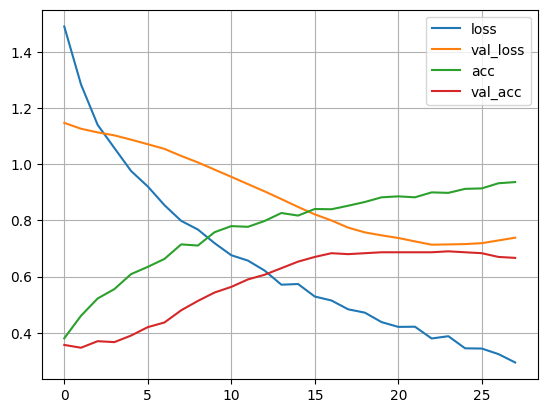

In [70]:
# A) Baseline: real data only
baseline_model, baseline_history, baseline_test = train_and_evaluate(
    X_train_ts,
    X_train_static_proc,
    y_train,
    description="Baseline (real only)"
)


First test with augmented data (real and synthetic data)


=== Training model: Augmented (real + synthetic) ===
Epoch 1/30
50/50 - 11s - 217ms/step - acc: 0.3532 - loss: 1.4934 - prec_neutral: 0.7568 - prec_over: 0.7179 - prec_under: 0.7669 - rec_neutral: 0.2220 - rec_over: 0.2148 - rec_under: 0.2287 - top2_acc: 0.6833 - val_acc: 0.3800 - val_loss: 1.1245 - val_prec_neutral: 0.0000e+00 - val_prec_over: 1.0000 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0042 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7333
Epoch 2/30
50/50 - 2s - 47ms/step - acc: 0.3898 - loss: 1.4041 - prec_neutral: 0.5384 - prec_over: 0.6350 - prec_under: 0.6476 - rec_neutral: 0.2598 - rec_over: 0.2022 - rec_under: 0.1984 - top2_acc: 0.7118 - val_acc: 0.3967 - val_loss: 1.1149 - val_prec_neutral: 0.0000e+00 - val_prec_over: 1.0000 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0042 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.7300
Epoch 3/30
50/50 - 2s - 43ms/step - acc: 0.4154 - loss: 1.3260 - prec_neutral: 0

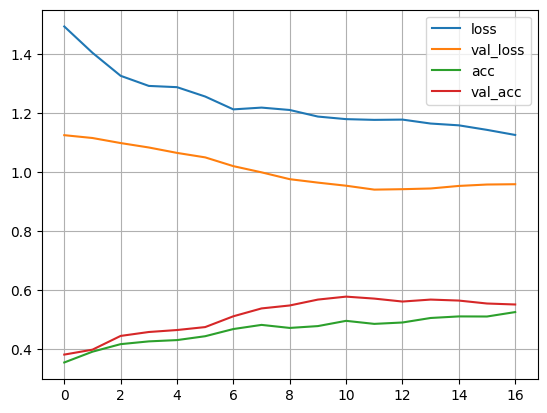

In [74]:
# B) Augmented: real + synthetic
aug_model, aug_history, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (real + synthetic)"
)

Adding synthetic data with the current GAN significantly decreases performance. We will have to ensure the GAN is producing more accurate synthetic data. It appears the static features and labels don't match the synthetic time series resulting in conflicting signals. We need a way to make this synthetic dataset agree. We will also reduce the amount of synthetic data generated to start with only 200 samples per class.
New cleaner implementation:

In [75]:
def generate_synthetic_dataset(generator,
                               X_train_ts,
                               X_train_static_proc,
                               y_train,
                               n_per_class=200):
    """
    Generate synthetic (ts, static, label) triples where
    static features and labels match the GAN label.
    """
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    latent_dim = generator.input_shape[0][-1]

    syn_ts_list = []
    syn_static_list = []
    syn_y_list = []

    for cls in range(3):
        # indices of real samples for this class
        real_idx_cls = np.where(y_train == cls)[0]
        if real_idx_cls.size == 0:
            continue

        # how many synthetic samples to create for this class
        n_gen = min(n_per_class, real_idx_cls.size)

        # generate synthetic time series for this class
        noise = np.random.normal(0, 1, (n_gen, latent_dim))
        labels = np.full((n_gen, 1), cls, dtype="int32")
        fake_ts = generator.predict([noise, labels], verbose=0)

        # sample static features from real stocks with label cls
        chosen_idx = np.random.choice(real_idx_cls, size=n_gen, replace=True)
        static_cls = X_train_static_proc[chosen_idx]

        syn_ts_list.append(fake_ts)
        syn_static_list.append(static_cls)
        syn_y_list.append(np.full(n_gen, cls, dtype="int32"))

    if not syn_ts_list:
        raise ValueError("No synthetic samples generated; check class labels.")

    syn_ts = np.vstack(syn_ts_list)
    syn_static = np.vstack(syn_static_list)
    syn_y = np.concatenate(syn_y_list)

    return syn_ts, syn_static, syn_y


In [ ]:
def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    body = layers.Dense(n_timesteps * 64, activation='relu')(merged)
    body = layers.Reshape((n_timesteps, 64))(body)

    body = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(body)
    body = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(body)
    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='linear')(body)

    return tf.keras.Model([noise_input, label_input], out, name='generator')


def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    body = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='relu')(merged)
    body = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', activation='relu')(body)
    body = layers.GlobalAveragePooling1D()(body)
    out = layers.Dense(1, activation='sigmoid')(body)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')


Code to train GAN

In [ ]:
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)


Now code to build datasets and train then test

Epoch 0, D loss: 0.6614, G loss: 0.6738
Epoch 1, D loss: 0.6394, G loss: 0.6651
Epoch 2, D loss: 0.6200, G loss: 0.6584
Epoch 3, D loss: 0.6022, G loss: 0.6538
Epoch 4, D loss: 0.5856, G loss: 0.6519
Epoch 5, D loss: 0.5697, G loss: 0.6538
Epoch 6, D loss: 0.5539, G loss: 0.6590
Epoch 7, D loss: 0.5386, G loss: 0.6657
Epoch 8, D loss: 0.5249, G loss: 0.6718
Epoch 9, D loss: 0.5134, G loss: 0.6765
Epoch 10, D loss: 0.5040, G loss: 0.6789
Epoch 11, D loss: 0.4971, G loss: 0.6785
Epoch 12, D loss: 0.4926, G loss: 0.6748
Epoch 13, D loss: 0.4902, G loss: 0.6686
Epoch 14, D loss: 0.4899, G loss: 0.6602
Epoch 15, D loss: 0.4921, G loss: 0.6493
Epoch 16, D loss: 0.4981, G loss: 0.6352
Epoch 17, D loss: 0.5079, G loss: 0.6185
Epoch 18, D loss: 0.5200, G loss: 0.6014
Epoch 19, D loss: 0.5331, G loss: 0.5849
Epoch 20, D loss: 0.5456, G loss: 0.5696
Epoch 21, D loss: 0.5567, G loss: 0.5564
Epoch 22, D loss: 0.5652, G loss: 0.5458
Epoch 23, D loss: 0.5698, G loss: 0.5391
Epoch 24, D loss: 0.5702, 

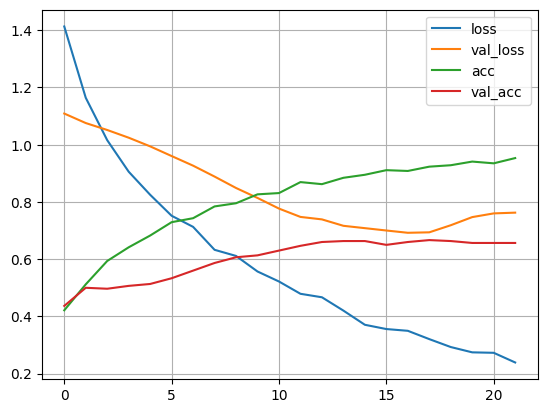

In [77]:
# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=200  # tune this
)

# 3) Build augmented training sets
X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

# show results

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (real + synthetic)"
)


Performance on the neutral class is mostly the one that needs improvement so we will limit the synthetic data to be only for the neutral class.

In [78]:
def generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=200,
    classes_to_augment=(0, 1, 2),
):
    """
    Generate synthetic (ts, static, label) triples where
    static features and labels match the GAN label.
    Only for the classes in classes_to_augment.
    """
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    latent_dim = generator.input_shape[0][-1]

    syn_ts_list = []
    syn_static_list = []
    syn_y_list = []

    for cls in classes_to_augment:
        real_idx_cls = np.where(y_train == cls)[0]
        if real_idx_cls.size == 0:
            continue

        n_gen = min(n_per_class, real_idx_cls.size)

        noise = np.random.normal(0, 1, (n_gen, latent_dim))
        labels = np.full((n_gen, 1), cls, dtype="int32")
        fake_ts = generator.predict([noise, labels], verbose=0)

        chosen_idx = np.random.choice(real_idx_cls, size=n_gen, replace=True)
        static_cls = X_train_static_proc[chosen_idx]

        syn_ts_list.append(fake_ts)
        syn_static_list.append(static_cls)
        syn_y_list.append(np.full(n_gen, cls, dtype="int32"))

    if not syn_ts_list:
        raise ValueError("No synthetic samples generated; check class labels.")

    syn_ts = np.vstack(syn_ts_list)
    syn_static = np.vstack(syn_static_list)
    syn_y = np.concatenate(syn_y_list)

    return syn_ts, syn_static, syn_y


Now retrain model with neutral class augmentation only


=== Training model: Augmented (neutral only) ===
Epoch 1/30
22/22 - 8s - 363ms/step - acc: 0.3109 - loss: 1.7686 - prec_neutral: 0.6997 - prec_over: 0.8144 - prec_under: 0.7707 - rec_neutral: 0.2412 - rec_over: 0.2572 - rec_under: 0.2243 - top2_acc: 0.6612 - val_acc: 0.3333 - val_loss: 1.1551 - val_prec_neutral: 0.7500 - val_prec_over: 0.8421 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0127 - val_rec_over: 0.0678 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6567
Epoch 2/30
22/22 - 1s - 61ms/step - acc: 0.4096 - loss: 1.4450 - prec_neutral: 0.8735 - prec_over: 0.9226 - prec_under: 0.7457 - rec_neutral: 0.3090 - rec_over: 0.2250 - rec_under: 0.2011 - top2_acc: 0.7541 - val_acc: 0.3600 - val_loss: 1.1383 - val_prec_neutral: 0.6667 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0339 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6800
Epoch 3/30
22/22 - 1s - 60ms/step - acc: 0.5154 - loss: 1.1707 - prec_neutral: 0.6414 - prec_

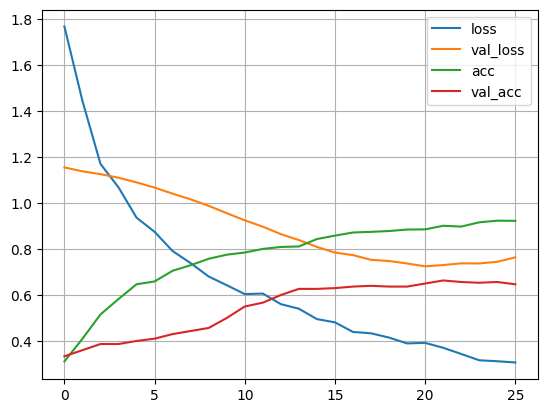

In [79]:
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=200,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)


Test if fewer generated neutral augmented data results in better performance, down to 50 from 200


=== Training model: Augmented (neutral only) ===
Epoch 1/30
20/20 - 9s - 443ms/step - acc: 0.3619 - loss: 1.5226 - prec_neutral: 0.7943 - prec_over: 0.5763 - prec_under: 0.6873 - rec_neutral: 0.2451 - rec_over: 0.2415 - rec_under: 0.2272 - top2_acc: 0.6878 - val_acc: 0.3367 - val_loss: 1.1783 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6500
Epoch 2/30
20/20 - 1s - 65ms/step - acc: 0.4484 - loss: 1.2895 - prec_neutral: 0.6398 - prec_over: 0.6215 - prec_under: 0.8152 - rec_neutral: 0.2572 - rec_over: 0.2031 - rec_under: 0.2266 - top2_acc: 0.7790 - val_acc: 0.3600 - val_loss: 1.1637 - val_prec_neutral: 0.0000e+00 - val_prec_over: 0.0000e+00 - val_prec_under: 0.0000e+00 - val_rec_neutral: 0.0000e+00 - val_rec_over: 0.0000e+00 - val_rec_under: 0.0000e+00 - val_top2_acc: 0.6500
Epoch 3/30
20/20 - 1s - 52ms/step - acc: 0.5100 - loss: 1.1535 - prec

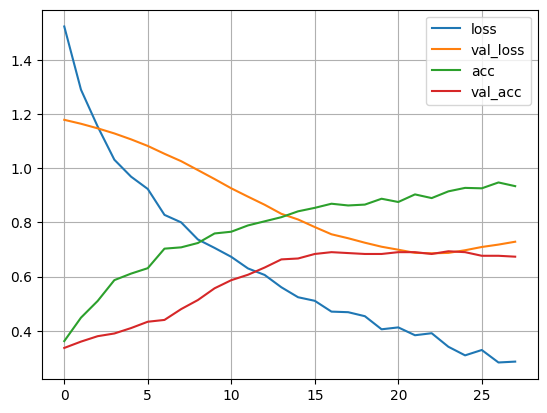

In [80]:
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)


The results seem to be largely the same, we will now investigate changing some of the architecture to use Adam instead of RMSprop

Epoch 0, D loss: 0.7087, G loss: 0.7007
Epoch 1, D loss: 0.6747, G loss: 0.6800
Epoch 2, D loss: 0.6515, G loss: 0.6645
Epoch 3, D loss: 0.6466, G loss: 0.6491
Epoch 4, D loss: 0.6416, G loss: 0.6551
Epoch 5, D loss: 0.6374, G loss: 0.6697
Epoch 6, D loss: 0.6342, G loss: 0.6796
Epoch 7, D loss: 0.6326, G loss: 0.6784
Epoch 8, D loss: 0.6272, G loss: 0.6811
Epoch 9, D loss: 0.6310, G loss: 0.6767
Epoch 10, D loss: 0.6282, G loss: 0.6876
Epoch 11, D loss: 0.6318, G loss: 0.6876
Epoch 12, D loss: 0.6343, G loss: 0.6911
Epoch 13, D loss: 0.6348, G loss: 0.6931
Epoch 14, D loss: 0.6327, G loss: 0.6974
Epoch 15, D loss: 0.6304, G loss: 0.7029
Epoch 16, D loss: 0.6289, G loss: 0.7066
Epoch 17, D loss: 0.6273, G loss: 0.7110
Epoch 18, D loss: 0.6282, G loss: 0.7067
Epoch 19, D loss: 0.6319, G loss: 0.7011
Epoch 20, D loss: 0.6311, G loss: 0.7082
Epoch 21, D loss: 0.6326, G loss: 0.7123
Epoch 22, D loss: 0.6364, G loss: 0.7124
Epoch 23, D loss: 0.6393, G loss: 0.7171
Epoch 24, D loss: 0.6417, 

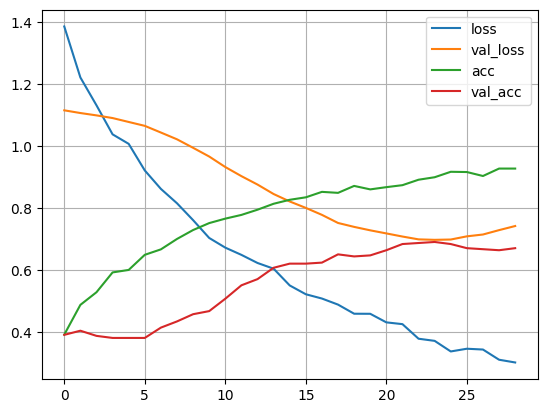

In [82]:
# change to Adam
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



Performance now looks similar to the baseline except precision for over has increased but the neutral precision remains the same. We will now attempt to adjust the generator to add batch normalization and use LeakyRelU instead of ReLU to test performance, and change the output activation function to tanh

In [90]:
def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    # add batch normalization and leakyReLU
    body = layers.Dense(n_timesteps * 64, use_bias=False, name='gen_dense')(merged)
    body = layers.BatchNormalization(name='gen_batch_norm_1')(body)
    body = layers.LeakyReLU()(body)
    body = layers.Reshape((n_timesteps, 64))(body)

    body = layers.Conv1D(64, kernel_size=5, padding='same', use_bias=False, name='gen_conv_1')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_2')(body)
    body = layers.LeakyReLU()(body)

    body = layers.Conv1D(32, kernel_size=3, padding='same', use_bias=False, name='gen_conv_2')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_3')(body)
    body = layers.LeakyReLU()(body)

    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='tanh')(body)

    return tf.keras.Model([noise_input, label_input], out, name='generator')


def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    body = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='relu')(merged)
    body = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', activation='relu')(body)
    body = layers.GlobalAveragePooling1D()(body)
    out = layers.Dense(1, activation='sigmoid')(body)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')


Epoch 0, D loss: 0.7034, G loss: 0.7330
Epoch 1, D loss: 0.6640, G loss: 0.6135
Epoch 2, D loss: 0.6369, G loss: 0.5213
Epoch 3, D loss: 0.6168, G loss: 0.4488
Epoch 4, D loss: 0.5998, G loss: 0.3912
Epoch 5, D loss: 0.5874, G loss: 0.3454
Epoch 6, D loss: 0.5798, G loss: 0.3111
Epoch 7, D loss: 0.5749, G loss: 0.2853
Epoch 8, D loss: 0.5733, G loss: 0.2641
Epoch 9, D loss: 0.5719, G loss: 0.2465
Epoch 10, D loss: 0.5661, G loss: 0.2326
Epoch 11, D loss: 0.5572, G loss: 0.2213
Epoch 12, D loss: 0.5459, G loss: 0.2132
Epoch 13, D loss: 0.5310, G loss: 0.2087
Epoch 14, D loss: 0.5125, G loss: 0.2048
Epoch 15, D loss: 0.4937, G loss: 0.1991
Epoch 16, D loss: 0.4764, G loss: 0.1924
Epoch 17, D loss: 0.4621, G loss: 0.1853
Epoch 18, D loss: 0.4504, G loss: 0.1785
Epoch 19, D loss: 0.4408, G loss: 0.1723
Epoch 20, D loss: 0.4332, G loss: 0.1668
Epoch 21, D loss: 0.4287, G loss: 0.1618
Epoch 22, D loss: 0.4295, G loss: 0.1571
Epoch 23, D loss: 0.4358, G loss: 0.1533
Epoch 24, D loss: 0.4444, 

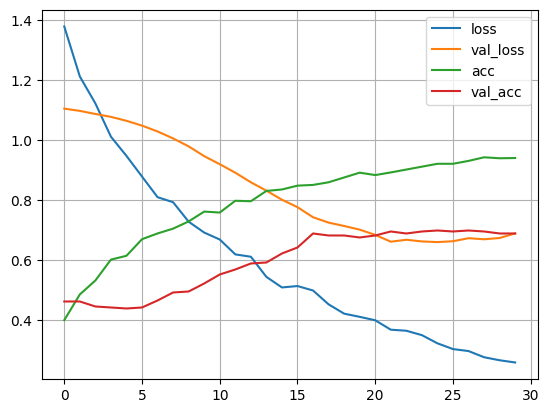

In [91]:
# change to Adam
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



These changes slightly improved the neutral precision and increased the accuracy. We will now test another minor change to the GAN structure by adding batch normalization in the discriminator and replace the pooling layer with strided convolution

In [96]:
def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    # add batch normalization and leakyReLU
    body = layers.Dense(n_timesteps * 64, use_bias=False, name='gen_dense')(merged)
    body = layers.BatchNormalization(name='gen_batch_norm_1')(body)
    body = layers.LeakyReLU()(body)
    body = layers.Reshape((n_timesteps, 64))(body)

    body = layers.Conv1D(64, kernel_size=5, padding='same', use_bias=False, name='gen_conv_1')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_2')(body)
    body = layers.LeakyReLU()(body)

    body = layers.Conv1D(32, kernel_size=3, padding='same', use_bias=False, name='gen_conv_2')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_3')(body)
    body = layers.LeakyReLU()(body)

    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='tanh')(body)

    return tf.keras.Model([noise_input, label_input], out, name='generator')


def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    # add batch normalization and use leakyReLU in discriminator
    body = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', name='disc_conv_1')(merged)
    body = layers.BatchNormalization(name='disc_batch_norm_1')(body)
    body = layers.LeakyReLU()(body)
    body = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', name='disc_conv_2')(body)
    body = layers.BatchNormalization(name='disc_batch_norm_2')(body)
    body = layers.LeakyReLU()(body)
    # replace global average pooling with strided convoluted layer
    body = layers.Conv1D(128, kernel_size=5, strides=2, padding='same', name='disc_conv_3')(body)
    body = layers.BatchNormalization(name='disc_batch_norm_3')(body)
    body = layers.LeakyReLU()(body)
    # add flatten to match expected shape
    body = layers.Flatten(name='disc_flatten')(body)
    out = layers.Dense(1, activation='sigmoid')(body)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')


In [97]:
# run again with new GAN architecture
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



Epoch 0, D loss: 0.9638, G loss: 0.6049
Epoch 1, D loss: 0.9868, G loss: 0.5210
Epoch 2, D loss: 0.8190, G loss: 0.4367
Epoch 3, D loss: 0.6843, G loss: 0.3540
Epoch 4, D loss: 0.5741, G loss: 0.2877
Epoch 5, D loss: 0.4887, G loss: 0.2389
Epoch 6, D loss: 0.4231, G loss: 0.2032
Epoch 7, D loss: 0.3723, G loss: 0.1766
Epoch 8, D loss: 0.3322, G loss: 0.1561
Epoch 9, D loss: 0.2999, G loss: 0.1398
Epoch 10, D loss: 0.2734, G loss: 0.1266
Epoch 11, D loss: 0.2513, G loss: 0.1157
Epoch 12, D loss: 0.2326, G loss: 0.1066
Epoch 13, D loss: 0.2166, G loss: 0.0988
Epoch 14, D loss: 0.2028, G loss: 0.0921
Epoch 15, D loss: 0.1907, G loss: 0.0863
Epoch 16, D loss: 0.1801, G loss: 0.0812
Epoch 17, D loss: 0.1707, G loss: 0.0767
Epoch 18, D loss: 0.1624, G loss: 0.0727
Epoch 19, D loss: 0.1550, G loss: 0.0692
Epoch 20, D loss: 0.1483, G loss: 0.0661
Epoch 21, D loss: 0.1424, G loss: 0.0632
Epoch 22, D loss: 0.1372, G loss: 0.0607
Epoch 23, D loss: 0.1326, G loss: 0.0584
Epoch 24, D loss: 0.1285, 

KeyboardInterrupt: 

Mode collapse occurred so we will stop this attempt and remove batch normalization from the discriminator

In [98]:
def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    # add batch normalization and leakyReLU
    body = layers.Dense(n_timesteps * 64, use_bias=False, name='gen_dense')(merged)
    body = layers.BatchNormalization(name='gen_batch_norm_1')(body)
    body = layers.LeakyReLU()(body)
    body = layers.Reshape((n_timesteps, 64))(body)

    body = layers.Conv1D(64, kernel_size=5, padding='same', use_bias=False, name='gen_conv_1')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_2')(body)
    body = layers.LeakyReLU()(body)

    body = layers.Conv1D(32, kernel_size=3, padding='same', use_bias=False, name='gen_conv_2')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_3')(body)
    body = layers.LeakyReLU()(body)

    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='tanh')(body)

    return tf.keras.Model([noise_input, label_input], out, name='generator')


def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    # add batch normalization and use leakyReLU in discriminator
    body = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', name='disc_conv_1')(merged)
    body = layers.LeakyReLU()(body)
    body = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', name='disc_conv_2')(body)
    body = layers.LeakyReLU()(body)
    # replace global average pooling with strided convoluted layer
    body = layers.Conv1D(128, kernel_size=5, strides=2, padding='same', name='disc_conv_3')(body)
    body = layers.LeakyReLU()(body)
    # add flatten to match expected shape
    body = layers.Flatten(name='disc_flatten')(body)
    out = layers.Dense(1, activation='sigmoid')(body)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')


Epoch 0, D loss: 0.6389, G loss: 0.4762
Epoch 1, D loss: 0.5484, G loss: 0.2513
Epoch 2, D loss: 0.4468, G loss: 0.1599
Epoch 3, D loss: 0.3368, G loss: 0.1145
Epoch 4, D loss: 0.2648, G loss: 0.0891
Epoch 5, D loss: 0.2180, G loss: 0.0729
Epoch 6, D loss: 0.1854, G loss: 0.0617
Epoch 7, D loss: 0.1614, G loss: 0.0534
Epoch 8, D loss: 0.1430, G loss: 0.0472
Epoch 9, D loss: 0.1285, G loss: 0.0422
Epoch 10, D loss: 0.1167, G loss: 0.0382
Epoch 11, D loss: 0.1073, G loss: 0.0349
Epoch 12, D loss: 0.1223, G loss: 0.0346
Epoch 13, D loss: 0.1356, G loss: 0.0338
Epoch 14, D loss: 0.1400, G loss: 0.0382
Epoch 15, D loss: 0.1700, G loss: 0.0527
Epoch 16, D loss: 0.1834, G loss: 0.0574
Epoch 17, D loss: 0.1955, G loss: 0.0652
Epoch 18, D loss: 0.2018, G loss: 0.0700
Epoch 19, D loss: 0.2040, G loss: 0.0745
Epoch 20, D loss: 0.2086, G loss: 0.0836
Epoch 21, D loss: 0.2081, G loss: 0.0879
Epoch 22, D loss: 0.2035, G loss: 0.0886
Epoch 23, D loss: 0.1984, G loss: 0.0883
Epoch 24, D loss: 0.1932, 

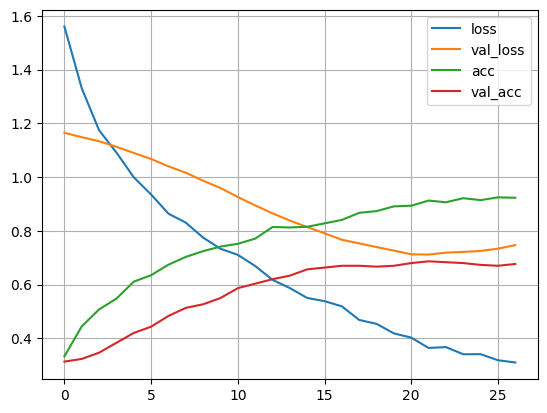

In [99]:
# run again with new GAN architecture
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



No discernible change now compared to baseline, we will check how close the augmented data is to the actual dataset

In [100]:
stats_df = compare_real_fake_stats(generator, X_train_ts, y_train)
print(stats_df)

   class  mean_abs_mean_diff  mean_abs_std_diff
0      0            0.179898           0.934629
1      1            0.211195           0.504492
2      2            0.114986           0.741148


The generator roughly matches the average value but it does not match the volatility for any class. Check if linear output is better

In [101]:
def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    # add batch normalization and leakyReLU
    body = layers.Dense(n_timesteps * 64, use_bias=False, name='gen_dense')(merged)
    body = layers.BatchNormalization(name='gen_batch_norm_1')(body)
    body = layers.LeakyReLU()(body)
    body = layers.Reshape((n_timesteps, 64))(body)

    body = layers.Conv1D(64, kernel_size=5, padding='same', use_bias=False, name='gen_conv_1')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_2')(body)
    body = layers.LeakyReLU()(body)

    body = layers.Conv1D(32, kernel_size=3, padding='same', use_bias=False, name='gen_conv_2')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_3')(body)
    body = layers.LeakyReLU()(body)

    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='linear')(body)

    return tf.keras.Model([noise_input, label_input], out, name='generator')


def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    # add batch normalization and use leakyReLU in discriminator
    body = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', name='disc_conv_1')(merged)
    body = layers.LeakyReLU()(body)
    body = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', name='disc_conv_2')(body)
    body = layers.LeakyReLU()(body)
    # replace global average pooling with strided convoluted layer
    body = layers.Conv1D(128, kernel_size=5, strides=2, padding='same', name='disc_conv_3')(body)
    body = layers.LeakyReLU()(body)
    # add flatten to match expected shape
    body = layers.Flatten(name='disc_flatten')(body)
    out = layers.Dense(1, activation='sigmoid')(body)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')


Epoch 0, D loss: 0.6625, G loss: 0.4814
Epoch 1, D loss: 0.5685, G loss: 0.2049
Epoch 2, D loss: 0.4761, G loss: 0.1238
Epoch 3, D loss: 0.3593, G loss: 0.0883
Epoch 4, D loss: 0.2811, G loss: 0.0686
Epoch 5, D loss: 0.2305, G loss: 0.0561
Epoch 6, D loss: 0.1952, G loss: 0.0475
Epoch 7, D loss: 0.1693, G loss: 0.0412
Epoch 8, D loss: 0.1495, G loss: 0.0363
Epoch 9, D loss: 0.1338, G loss: 0.0325
Epoch 10, D loss: 0.1211, G loss: 0.0294
Epoch 11, D loss: 0.1106, G loss: 0.0269
Epoch 12, D loss: 0.1018, G loss: 0.0247
Epoch 13, D loss: 0.0943, G loss: 0.0229
Epoch 14, D loss: 0.0879, G loss: 0.0213
Epoch 15, D loss: 0.0822, G loss: 0.0199
Epoch 16, D loss: 0.0773, G loss: 0.0187
Epoch 17, D loss: 0.0729, G loss: 0.0177
Epoch 18, D loss: 0.0691, G loss: 0.0167
Epoch 19, D loss: 0.0656, G loss: 0.0159
Epoch 20, D loss: 0.0625, G loss: 0.0151
Epoch 21, D loss: 0.0596, G loss: 0.0144
Epoch 22, D loss: 0.0570, G loss: 0.0137
Epoch 23, D loss: 0.0546, G loss: 0.0132
Epoch 24, D loss: 0.0748, 

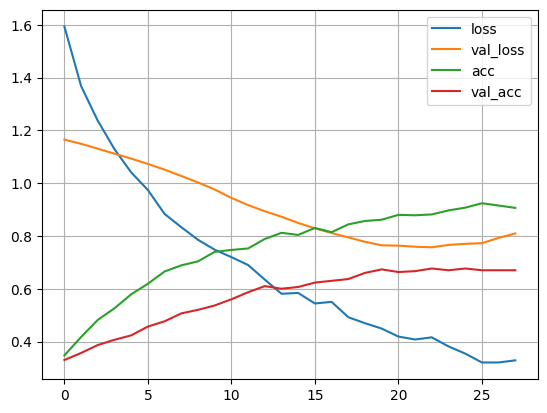

In [102]:
# run again with linear output
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



Performance is worse, we will change the scaler to use a min max scaler instead of standard scaler and change back to tanh activation

In [109]:
def build_generator(n_timesteps, n_channels, latent_dim=64):
    noise_input = layers.Input(shape=(latent_dim,), name='noise_input')
    label_input = layers.Input(shape=(1,), dtype='int32', name='class_label')

    label_embedding = layers.Embedding(input_dim=3, output_dim=latent_dim)(label_input)
    label_vec = layers.Flatten()(label_embedding)
    merged = layers.Concatenate()([noise_input, label_vec])

    # add batch normalization and leakyReLU
    body = layers.Dense(n_timesteps * 64, use_bias=False, name='gen_dense')(merged)
    body = layers.BatchNormalization(name='gen_batch_norm_1')(body)
    body = layers.LeakyReLU()(body)
    body = layers.Reshape((n_timesteps, 64))(body)

    body = layers.Conv1D(64, kernel_size=5, padding='same', use_bias=False, name='gen_conv_1')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_2')(body)
    body = layers.LeakyReLU()(body)

    body = layers.Conv1D(32, kernel_size=3, padding='same', use_bias=False, name='gen_conv_2')(body)
    body = layers.BatchNormalization(name='gen_batch_norm_3')(body)
    body = layers.LeakyReLU()(body)

    out = layers.Conv1D(n_channels, kernel_size=3, padding='same', activation='tanh')(body)

    return tf.keras.Model([noise_input, label_input], out, name='generator')


def build_discriminator(n_timesteps, n_channels):
    ts_input = layers.Input(shape=(n_timesteps, n_channels))
    label_input = layers.Input(shape=(1,))

    label_embedding = layers.Embedding(input_dim=3, output_dim=n_timesteps)(label_input)
    label_map = layers.Reshape((n_timesteps, 1))(label_embedding)

    merged = layers.Concatenate(axis=2)([ts_input, label_map])

    # add batch normalization and use leakyReLU in discriminator
    body = layers.Conv1D(32, kernel_size=5, strides=2, padding='same', name='disc_conv_1')(merged)
    body = layers.LeakyReLU()(body)
    body = layers.Conv1D(64, kernel_size=5, strides=2, padding='same', name='disc_conv_2')(body)
    body = layers.LeakyReLU()(body)
    # replace global average pooling with strided convoluted layer
    body = layers.Conv1D(128, kernel_size=5, strides=2, padding='same', name='disc_conv_3')(body)
    body = layers.LeakyReLU()(body)
    # add flatten to match expected shape
    body = layers.Flatten(name='disc_flatten')(body)
    out = layers.Dense(1, activation='sigmoid')(body)

    return tf.keras.Model([ts_input, label_input], out, name='discriminator')


Epoch 0, D loss: 0.6100, G loss: 0.6906
Epoch 1, D loss: 0.4601, G loss: 0.6102
Epoch 2, D loss: 0.3674, G loss: 0.5861
Epoch 3, D loss: 0.2787, G loss: 0.4644
Epoch 4, D loss: 0.2231, G loss: 0.3702
Epoch 5, D loss: 0.1886, G loss: 0.3075
Epoch 6, D loss: 0.1639, G loss: 0.2629
Epoch 7, D loss: 0.1436, G loss: 0.2295
Epoch 8, D loss: 0.1282, G loss: 0.2042
Epoch 9, D loss: 0.1168, G loss: 0.1959
Epoch 10, D loss: 0.1083, G loss: 0.2426
Epoch 11, D loss: 0.1015, G loss: 0.3902
Epoch 12, D loss: 0.0962, G loss: 0.5697
Epoch 13, D loss: 0.0981, G loss: 0.6751
Epoch 14, D loss: 0.1012, G loss: 0.8086
Epoch 15, D loss: 0.0971, G loss: 0.8252
Epoch 16, D loss: 0.1028, G loss: 0.8341
Epoch 17, D loss: 0.1271, G loss: 0.8782
Epoch 18, D loss: 0.1364, G loss: 0.8976
Epoch 19, D loss: 0.1434, G loss: 0.8821
Epoch 20, D loss: 0.1499, G loss: 0.8847
Epoch 21, D loss: 0.1587, G loss: 0.8871
Epoch 22, D loss: 0.1730, G loss: 0.8772
Epoch 23, D loss: 0.1837, G loss: 0.8549
Epoch 24, D loss: 0.2103, 

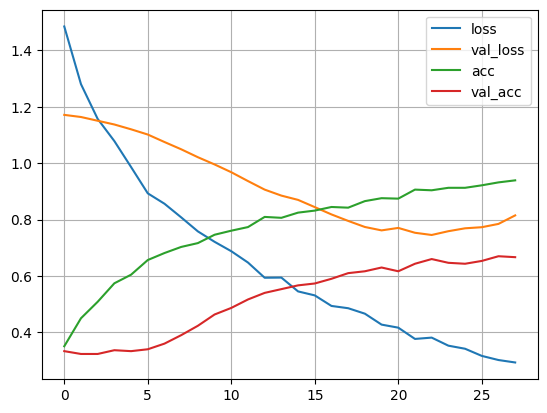

In [110]:
# run again with linear output
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50,
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



In [111]:
stats_df = compare_real_fake_stats(generator, X_train_ts, y_train)
print(stats_df)

   class  mean_abs_mean_diff  mean_abs_std_diff
0      0            0.022804           0.077164
1      1            0.010701           0.024429
2      2            0.011828           0.035339


We have now trained an effective GAN for generating more neutral data and have found that it actually decreases the performance of our model. The synthetic samples don't carry enough new discriminative information to help the classifier. Therefore, in this setting the best GAN-augmented model is still slightly worse than the clean real-only model suggesting that GAN-based augmentation for this use is not beneficial. To further show this we will increase the amount of neutral to 100 and see if the performance decreases further.

Epoch 0, D loss: 0.5271, G loss: 0.6341
Epoch 1, D loss: 0.4028, G loss: 0.6931
Epoch 2, D loss: 0.3013, G loss: 0.7578
Epoch 3, D loss: 0.2264, G loss: 0.6284
Epoch 4, D loss: 0.1817, G loss: 0.5239
Epoch 5, D loss: 0.1511, G loss: 0.4631
Epoch 6, D loss: 0.1297, G loss: 0.4310
Epoch 7, D loss: 0.1148, G loss: 0.5042
Epoch 8, D loss: 0.1044, G loss: 0.6707
Epoch 9, D loss: 0.0944, G loss: 0.7996
Epoch 10, D loss: 0.0866, G loss: 0.9213
Epoch 11, D loss: 0.0805, G loss: 1.0931
Epoch 12, D loss: 0.0813, G loss: 1.2443
Epoch 13, D loss: 0.0958, G loss: 1.3486
Epoch 14, D loss: 0.0946, G loss: 1.3518
Epoch 15, D loss: 0.0931, G loss: 1.3258
Epoch 16, D loss: 0.0902, G loss: 1.2903
Epoch 17, D loss: 0.1209, G loss: 1.2719
Epoch 18, D loss: 0.1321, G loss: 1.2488
Epoch 19, D loss: 0.1349, G loss: 1.2482
Epoch 20, D loss: 0.1403, G loss: 1.2337
Epoch 21, D loss: 0.1460, G loss: 1.2247
Epoch 22, D loss: 0.1598, G loss: 1.2272
Epoch 23, D loss: 0.1724, G loss: 1.2240
Epoch 24, D loss: 0.1895, 

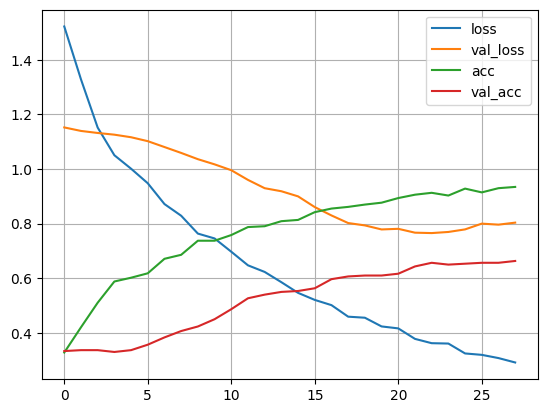

In [ ]:
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=100, # increased the number of neutrals sampled
    classes_to_augment=(1,)  # only neutral
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (neutral only)"
)



In [113]:
stats_df = compare_real_fake_stats(generator, X_train_ts, y_train)
print(stats_df)

   class  mean_abs_mean_diff  mean_abs_std_diff
0      0            0.023598           0.075666
1      1            0.011188           0.019955
2      2            0.014992           0.042008


Test if adding each class improves the performance instead of just adding the neutral class

Epoch 0, D loss: 0.5800, G loss: 0.6087
Epoch 1, D loss: 0.4237, G loss: 0.5320
Epoch 2, D loss: 0.3204, G loss: 0.6794
Epoch 3, D loss: 0.2442, G loss: 0.6221
Epoch 4, D loss: 0.1977, G loss: 0.5155
Epoch 5, D loss: 0.1673, G loss: 0.4366
Epoch 6, D loss: 0.1458, G loss: 0.3792
Epoch 7, D loss: 0.1302, G loss: 0.3448
Epoch 8, D loss: 0.1198, G loss: 0.3675
Epoch 9, D loss: 0.1126, G loss: 0.4361
Epoch 10, D loss: 0.1049, G loss: 0.4942
Epoch 11, D loss: 0.1340, G loss: 0.7256
Epoch 12, D loss: 0.1333, G loss: 0.9717
Epoch 13, D loss: 0.1321, G loss: 1.1478
Epoch 14, D loss: 0.1289, G loss: 1.3555
Epoch 15, D loss: 0.1255, G loss: 1.4975
Epoch 16, D loss: 0.1230, G loss: 1.5833
Epoch 17, D loss: 0.1193, G loss: 1.6479
Epoch 18, D loss: 0.1167, G loss: 1.6554
Epoch 19, D loss: 0.1322, G loss: 1.6405
Epoch 20, D loss: 0.1437, G loss: 1.5840
Epoch 21, D loss: 0.1514, G loss: 1.5240
Epoch 22, D loss: 0.1593, G loss: 1.4902
Epoch 23, D loss: 0.1612, G loss: 1.5149
Epoch 24, D loss: 0.1644, 

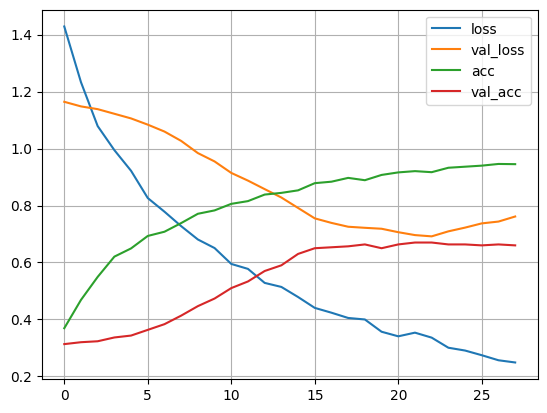

In [114]:
# run again with all classes added to composite dataset
def train_gan(X_train_ts, y_train, epochs=20, batch_size=64, latent_dim=64):
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    n_samples = X_train_ts.shape[0]

    generator = build_generator(n_timesteps, n_channels, latent_dim)
    discriminator = build_discriminator(n_timesteps, n_channels)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                          loss='binary_crossentropy')

    noise_dim = latent_dim
    gan_noise = layers.Input(shape=(noise_dim,))
    gan_label = layers.Input(shape=(1,), dtype='int32')
    fake_ts = generator([gan_noise, gan_label])

    discriminator.trainable = False
    gan_output = discriminator([fake_ts, gan_label])
    gan = tf.keras.Model([gan_noise, gan_label], gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
                loss='binary_crossentropy')
    
    steps_per_epoch = max(1, n_samples // batch_size)
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for step in range(steps_per_epoch):
            idx = np.random.randint(0, n_samples, batch_size)
            real_ts = X_train_ts[idx]
            real_labels = y_train[idx].reshape(-1, 1)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_labels = np.random.randint(0, 3, (batch_size, 1))
            fake_ts = generator.predict([noise, fake_labels], verbose=0)

            real_y = np.ones((batch_size, 1))
            fake_y = np.zeros((batch_size, 1))
        
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([real_ts, real_labels], real_y)
            d_loss_fake = discriminator.train_on_batch([fake_ts, fake_labels], fake_y)
            d_loss = 0.5 * (float(d_loss_real) + float(d_loss_fake))

            discriminator.trainable = False
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            rand_labels = np.random.randint(0, 3, (batch_size, 1))
            g_loss = float(
                gan.train_on_batch(
                    [noise, rand_labels],
                    np.ones((batch_size, 1), dtype='float32')
                )
            )

            d_loss_epoch.append(d_loss)
            g_loss_epoch.append(g_loss)
        
        d_mean = float(np.mean(d_loss_epoch))
        g_mean = float(np.mean(g_loss_epoch))
        d_losses.append(d_mean)
        g_losses.append(g_mean)
        print(f"Epoch {epoch}, D loss: {d_mean:.4f}, G loss: {g_mean:.4f}")

    return generator, np.array(d_losses), np.array(g_losses)

# 1) Train GAN (rerun this when you change GAN hyperparams/architecture)
generator, d_hist, g_hist = train_gan(
    X_train_ts,
    y_train,
    epochs=200,
    batch_size=64,
    latent_dim=64
)

# 2) Generate label-consistent synthetic dataset
syn_ts, syn_static, syn_labels = generate_synthetic_dataset(
    generator,
    X_train_ts,
    X_train_static_proc,
    y_train,
    n_per_class=50, # limit to 50 per class
    classes_to_augment=(0, 1, 2)  # all classes augmented
)

X_train_ts_aug = np.concatenate([X_train_ts, syn_ts], axis=0)
X_train_static_aug = np.concatenate([X_train_static_proc, syn_static], axis=0)
y_train_aug = np.concatenate([y_train, syn_labels], axis=0)

aug_model, aug_hist, aug_test = train_and_evaluate(
    X_train_ts_aug,
    X_train_static_aug,
    y_train_aug,
    description="Augmented (all classes)"
)


In [125]:
num_real = X_train_ts.shape[0]
synthetic_start = num_real

real_sample = X_train_ts[0]                     # (179, 8)
synth_sample = X_train_ts_aug[synthetic_start] # (179, 8)

real_df  = pd.DataFrame(real_sample,  columns=[f'ch_{i}' for i in range(8)])
synth_df = pd.DataFrame(synth_sample, columns=[f'ch_{i}' for i in range(8)])

print("REAL sample:")
print(real_df[['ch_0', 'ch_1', 'ch_2']].head())

print("\nSYNTHETIC sample:")
print(synth_df[['ch_0', 'ch_1', 'ch_2']].head())



REAL sample:
       ch_0      ch_1      ch_2
0 -0.980793 -0.980470 -0.980694
1 -0.980544 -0.981294 -0.980630
2 -0.981214 -0.981085 -0.981078
3 -0.981108 -0.981051 -0.981025
4 -0.981057 -0.980599 -0.980808

SYNTHETIC sample:
       ch_0      ch_1      ch_2
0 -0.986915 -0.986843 -0.978241
1 -0.989752 -0.993248 -0.986490
2 -0.980104 -0.956898 -0.964601
3 -0.991609 -0.981395 -0.995365
4 -0.997407 -0.995772 -0.993446


In [131]:
import numpy as np
import pandas as pd

def example_real_synth_table(generator, X_train_ts, y_train, cls=1, n_view=2, max_timesteps=5):
    """
    Build a small DataFrame showing real vs synthetic time-series channels
    for a given class. This is a 'human-readable' slice of the actual
    inputs that compare_real_fake_stats uses.
    """
    n_timesteps = X_train_ts.shape[1]
    n_channels = X_train_ts.shape[2]
    latent_dim = generator.input_shape[0][-1]

    # --- 1) pick some real samples from this class ---
    idx_cls = np.where(y_train == cls)[0]
    if idx_cls.size == 0:
        raise ValueError(f"No samples for class {cls}")
    idx_cls = idx_cls[:n_view]
    real_cls = X_train_ts[idx_cls]  # (n_view, T, C)

    # --- 2) generate same number of synthetic samples for this class ---
    noise = np.random.normal(0, 1, (n_view, latent_dim))
    labels = np.full((n_view, 1), cls, dtype="int32")
    fake_cls = generator.predict([noise, labels], verbose=0)  # (n_view, T, C)

    # --- 3) build a long-form table with source/sample/timestep/channels ---
    records = []
    for source, arr in [("real", real_cls), ("synthetic", fake_cls)]:
        for i in range(arr.shape[0]):         # sample index within this class
            for t in range(min(max_timesteps, arr.shape[1])):  # only first few timesteps
                row = {
                    "source": source,         # real or synthetic
                    "sample_idx": int(i),
                    "timestep": int(t),
                }
                for ch in range(n_channels):
                    row[f"ch_{ch}"] = float(arr[i, t, ch])
                records.append(row)

    df = pd.DataFrame(records)
    return df


In [132]:
# e.g. show class 1 (neutral), first 2 samples, first 5 timesteps
df_example = example_real_synth_table(generator, X_train_ts, y_train,
                                      cls=1, n_view=2, max_timesteps=5)
print(df_example)


       source  sample_idx  timestep      ch_0      ch_1      ch_2      ch_3  \
0        real           0         0 -0.913467 -0.914231 -0.913694 -0.914003   
1        real           0         1 -0.916439 -0.915803 -0.916380 -0.915670   
2        real           0         2 -0.914886 -0.913173 -0.914936 -0.911914   
3        real           0         3 -0.914136 -0.914179 -0.914321 -0.914242   
4        real           0         4 -0.913926 -0.912971 -0.913672 -0.913959   
5        real           1         0 -0.999162 -0.998915 -0.998945 -0.999091   
6        real           1         1 -0.998912 -0.998976 -0.998933 -0.998994   
7        real           1         2 -0.998945 -0.998973 -0.998942 -0.998937   
8        real           1         3 -0.998799 -0.999024 -0.998821 -0.999157   
9        real           1         4 -0.999032 -0.999159 -0.999050 -0.999117   
10  synthetic           0         0 -0.994939 -0.991131 -0.987608 -0.998093   
11  synthetic           0         1 -0.998640 -0.999